In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sources
- https://huggingface.co/google/mt5-base
- https://medium.com/@tskumar1320/how-to-fine-tune-pre-trained-language-translation-model-3e8a6aace9f
- https://www.geeksforgeeks.org/machine-translation-with-transformer-in-python/
- https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb
- https://thepythoncode.com/article/machine-translation-using-huggingface-transformers-in-python
- https://blog.speechmatics.com/huggingface-translation-triton
- https://github.com/christianversloot/machine-learning-articles/blob/main/easy-machine-translation-with-machine-learning-and-huggingface-transformers.md

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

## WANDB Config

In [3]:
!pip -q uninstall -y wandb
!pip -q install wandb==0.17.5 
import wandb
!wandb offline
!wandb disabled
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.5 MB/s eta 0:00:0000:0100:01
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [4]:
!pip -q install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00


In [5]:
!pip install -q datasets evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [6]:
!pip uninstall transformers -y
!pip -q install transformers==4.45.2

Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 71.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 89.9 MB/s eta 0:00:00


In [7]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import EvalPrediction
import evaluate

# Data Visualization

In [8]:
# Define file paths in a dictionary
train_file_paths = {
    'it': '/kaggle/input/semeval.train./semeval/train/it/train.jsonl',
    'ar': '/kaggle/input/semeval.train./semeval/train/ar/train.jsonl',
    'ja': '/kaggle/input/semeval.train./semeval/train/ja/train.jsonl',
}

# Load data from all files
train_data = {}
for lang, path in train_file_paths.items():
    with open(path, 'r', encoding='utf-8') as file:
        train_data[lang] = [json.loads(line) for line in file]

# Display a sample from each language
for lang, entries in train_data.items():
    print(f"First entry in {lang}:")
    print(entries[0])
    print('-' * 50)

First entry in it:
{'id': 'bff78c91', 'source_locale': 'en', 'target_locale': 'it', 'source': 'What year was the first book of the A Song of Ice and Fire series published?', 'target': 'In che anno venne pubblicato il primo libro della serie Cronache del Ghiaccio e del Fuoco?', 'entities': ['Q45875'], 'from': 'mintaka'}
--------------------------------------------------
First entry in ar:
{'id': 'a9011ddf', 'source_locale': 'en', 'target_locale': 'ar', 'source': 'What is the seventh tallest mountain in North America?', 'target': 'ما سابع أعلى جبل في أمريكا الشمالية؟', 'entities': ['Q49'], 'from': 'mintaka'}
--------------------------------------------------
First entry in ja:
{'id': 'a9011ddf', 'source_locale': 'en', 'target_locale': 'ja', 'source': 'What is the seventh tallest mountain in North America?', 'target': '北アメリカで七番目に高い山は何ですか？', 'entities': ['Q49'], 'from': 'mintaka'}
--------------------------------------------------


In [9]:
# Define file paths in a dictionary
valid_file_paths = {
    'it': '/kaggle/input/semeval.validation/validation/it_IT.jsonl',
    'ar': '/kaggle/input/semeval.validation/validation/ar_AE.jsonl',
    'ja': '/kaggle/input/semeval.validation/validation/ja_JP.jsonl',
}

# Load data from all files
valid_data = {}
for lang, path in valid_file_paths.items():
    with open(path, 'r', encoding='utf-8') as file:
        valid_data[lang] = [json.loads(line) for line in file]

# Display a sample from each language
for lang, entries in valid_data.items():
    print(f"First entry in {lang}:")
    print(entries[0])
    print('-' * 50)

First entry in it:
{'id': 'Q10357223_0', 'wikidata_id': 'Q10357223', 'entity_types': ['Person', 'Fictional entity'], 'source': 'What are some characteristics of the White Queen?', 'targets': [{'translation': 'Quali sono alcune caratteristiche della Regina Bianca?', 'mention': 'Regina Bianca'}], 'source_locale': 'en', 'target_locale': 'it'}
--------------------------------------------------
First entry in ar:
{'id': 'Q101438737_0', 'wikidata_id': 'Q101438737', 'entity_types': ['Artwork'], 'source': 'In what genre does A Promised Land fall?', 'targets': [{'translation': 'في أي نوع تقع الأرض الموعودة ؟', 'mention': 'الأرض الموعودة'}, {'translation': 'في أي نوع تقع الأرض الموعودة؟', 'mention': 'الأرض الموعودة'}, {'translation': 'في أي نوع يصنف الأرض الموعودة؟', 'mention': 'الأرض الموعودة'}], 'source_locale': 'en', 'target_locale': 'ar'}
--------------------------------------------------
First entry in ja:
{'id': 'Q1036741_0', 'wikidata_id': 'Q1036741', 'entity_types': ['Food'], 'source': '

In [10]:
# Define file paths in a dictionary
test_file_paths = {
    'it': '/kaggle/input/semeval.test_hidden/test_without_targets/it_IT.jsonl',
    'ar': '/kaggle/input/semeval.test_hidden/test_without_targets/ar_AE.jsonl',
    'ja': '/kaggle/input/semeval.test_hidden/test_without_targets/ja_JP.jsonl'
}

# Load data from all files
test_data = {}
for lang, path in test_file_paths.items():
    with open(path, 'r', encoding='utf-8') as file:
        test_data[lang] = [json.loads(line) for line in file]

# Display a sample from each language
for lang, entries in test_data.items():
    print(f"First entry in {lang}:")
    print(entries[0])
    print('-' * 50)

First entry in it:
{'id': 'e033d5afc49c9c27', 'wikidata_id': 'Q1009896', 'entity_types': ['Place of worship'], 'source': 'What is the significance of Šarena Mosque in Tetovo, North Macedonia?', 'targets': [], 'source_locale': 'en', 'target_locale': 'it'}
--------------------------------------------------
First entry in ar:
{'id': '5a6a722a7761adcb', 'wikidata_id': 'Q101245321', 'entity_types': ['Movie'], 'source': 'Who is the main character in Ainbo: Spirit of the Amazon?', 'targets': [], 'source_locale': 'en', 'target_locale': 'ar'}
--------------------------------------------------
First entry in ja:
{'id': '4423ee404edc07f7', 'wikidata_id': 'Q1006293', 'entity_types': ['Fictional entity'], 'source': 'What is the main goal of the Confederacy of Independent Systems?', 'targets': [], 'source_locale': 'en', 'target_locale': 'ja'}
--------------------------------------------------


In [14]:
len(test_data['ja'])

5108

In [12]:
len(train_data['ja'])

7225

In [13]:
len(valid_data['ja'])

723

In [38]:
import json

def flatten_validation_dataset(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            obj = json.loads(line)
            if 'targets' in obj:
                for idx, target in enumerate(obj['targets']):
                    new_obj = {
                        "id": f"{obj['id']}_{idx}",
                        "wikidata_id": obj['wikidata_id'],
                        "entity_types": obj['entity_types'],
                        "source": obj['source'],
                        "target": target['translation'],
                        "mention": [target['mention']],
                        "source_locale": obj['source_locale'],
                        "target_locale": obj['target_locale']
                    }
                    json.dump(new_obj, outfile)
                    outfile.write('\n')
            else:
                json.dump(obj, outfile)
                outfile.write('\n')

# Input and output file paths
input_file = '/kaggle/input/semeval.validation/validation/it_IT.jsonl'
output_file = 'flattened_validation_dataset.jsonl'

flatten_validation_dataset(input_file, output_file)

In [39]:
input_file = '/kaggle/input/semeval.validation/validation/ar_AE.jsonl'
output_file = 'flattened_validation_dataset_ar.jsonl'

flatten_validation_dataset(input_file, output_file)

In [40]:
input_file = '/kaggle/input/semeval.validation/validation/ja_JP.jsonl'
output_file = 'flattened_validation_dataset_ja.jsonl'

flatten_validation_dataset(input_file, output_file)

In [8]:
class TranslationDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        """
        Initializes the TranslationDataset.

        Args:
            file_path (str): Path to the JSONL file containing the pre-flattened data.
            tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for encoding.
            max_length (int): The maximum length for tokenized sequences.
        """
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = [json.loads(line) for line in f]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and labels for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing input IDs, attention mask, and labels.
        """
        item = self.data[idx]
        source = item['source']
        target = item['target']

        # Tokenize the source text
        inputs = self.tokenizer(
            source,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Tokenize the target text and prepare labels
        labels = self.tokenizer(
            target,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )['input_ids']
        # Replace padding token IDs with -100 for loss computation
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }



In [9]:
from peft import get_peft_model, LoraConfig, TaskType


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
        "fc1",
        "fc2"
    ]
)

In [10]:
# Step 3: Load Pre-trained Model and Tokenizer
model_name = "facebook/m2m100_418M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

In [10]:
print(model)

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100SdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

In [11]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 9,537,280 || all params: 493,442,816 || trainable%: 1.9328
None


In [12]:
# Step 4: Prepare Data
train_dataset = TranslationDataset('/kaggle/input/semeval.train./semeval/train/ar/train.jsonl',
                                   tokenizer)
dev_dataset = TranslationDataset('/kaggle/input/flattened_validation_dataset_ar.jsonl',
                                 tokenizer)

In [16]:
len(train_dataset)

3739

In [15]:
len(dev_dataset)

1268

In [14]:
dev_dataset.data[:3]

[{'id': 'Q10357223_0_0',
  'wikidata_id': 'Q10357223',
  'entity_types': ['Person', 'Fictional entity'],
  'source': 'What are some characteristics of the White Queen?',
  'target': 'Quali sono alcune caratteristiche della Regina Bianca?',
  'mention': ['Regina Bianca'],
  'source_locale': 'en',
  'target_locale': 'it'},
 {'id': 'Q10357223_1_0',
  'wikidata_id': 'Q10357223',
  'entity_types': ['Person', 'Fictional entity'],
  'source': 'What is the role of the White Queen in the story?',
  'target': 'Qual è il ruolo della Regina Bianca nella storia?',
  'mention': ['Regina Bianca'],
  'source_locale': 'en',
  'target_locale': 'it'},
 {'id': 'Q10357223_2_0',
  'wikidata_id': 'Q10357223',
  'entity_types': ['Person', 'Fictional entity'],
  'source': 'How does the White Queen interact with Alice in Through the Looking-Glass?',
  'target': 'In che modo la Regina Bianca interagisce con Alice in Through the Looking-Glass?',
  'mention': ['Regina Bianca'],
  'source_locale': 'en',
  'target_l

In [13]:
train_dataset.data[:5]

[{'id': 'bff78c91',
  'source_locale': 'en',
  'target_locale': 'it',
  'source': 'What year was the first book of the A Song of Ice and Fire series published?',
  'target': 'In che anno venne pubblicato il primo libro della serie Cronache del Ghiaccio e del Fuoco?',
  'entities': ['Q45875'],
  'from': 'mintaka'},
 {'id': 'f477742c',
  'source_locale': 'en',
  'target_locale': 'it',
  'source': "Which actor was Stephenie Meyer's first choice to play Edward Cullen in the movie Twilight?",
  'target': 'Quale attore era stata la prima scelta di Stephanie Meyer per interpretare Edward Cullen nel film Twilight?',
  'entities': ['Q160219'],
  'from': 'mintaka'},
 {'id': '2e3cf745',
  'source_locale': 'en',
  'target_locale': 'it',
  'source': 'Which river is longer than the Mississippi River?',
  'target': 'Quale fiume è più lungo del Mississippi?',
  'entities': ['Q1497'],
  'from': 'mintaka'},
 {'id': '650e81a3',
  'source_locale': 'en',
  'target_locale': 'it',
  'source': 'What is the lo

In [24]:
# Function to read JSONL and tokenize text
def get_token_counts(file_path, tokenizer):
    token_counts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            source_text = data['source']
            target_text = data['target']

            # Tokenize and count tokens
            source_tokens = len(tokenizer.tokenize(source_text))
            target_tokens = len(tokenizer.tokenize(target_text))

            # Store counts
            token_counts.append((source_tokens, target_tokens))
    
    return token_counts

In [25]:
# Paths to datasets
train_path = "/kaggle/input/semeval.train./semeval/train/ja/train.jsonl"
dev_path = "/kaggle/input/flattened_validation_dataset_ja.jsonl"
test_path = "/kaggle/input/semeval.test_hidden/test_without_targets/ja_JP.jsonl"

In [26]:
# Get token counts
train_counts = get_token_counts(train_path, tokenizer)
dev_counts = get_token_counts(dev_path, tokenizer)
# test_counts = get_token_counts(test_path, tokenizer)

In [27]:
# Convert to lists
train_source, train_target = zip(*train_counts)
dev_source, dev_target = zip(*dev_counts)
# test_source, test_target = zip(*test_counts)

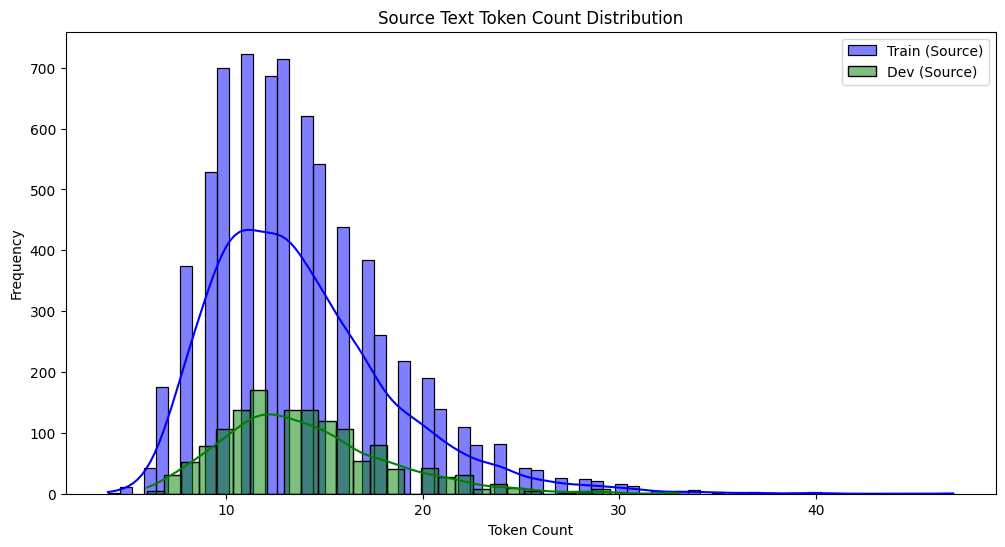

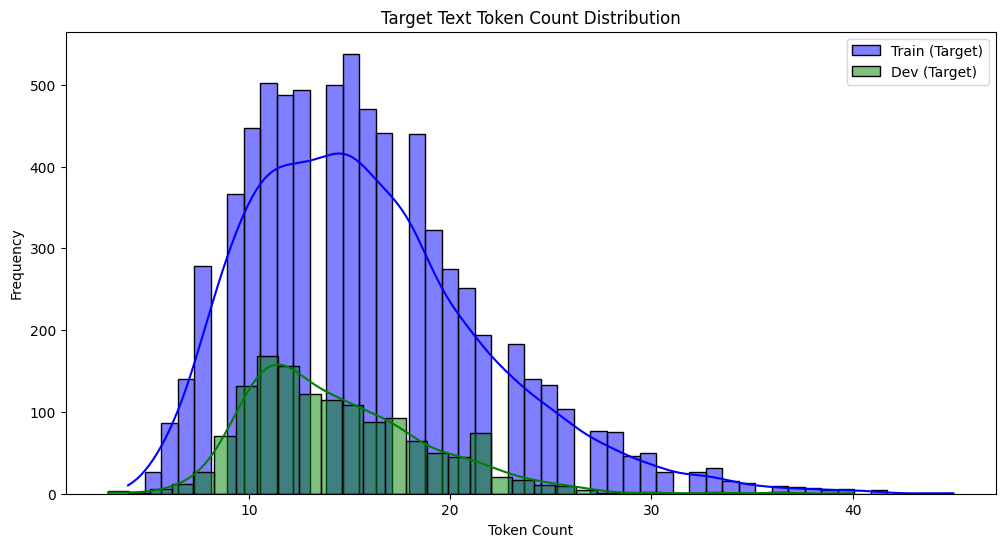

In [28]:
# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(train_source, label="Train (Source)", color="blue", kde=True, alpha=0.5)
sns.histplot(dev_source, label="Dev (Source)", color="green", kde=True, alpha=0.5)
# sns.histplot(test_source, label="Test (Source)", color="red", kde=True, alpha=0.5)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Source Text Token Count Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_target, label="Train (Target)", color="blue", kde=True, alpha=0.5)
sns.histplot(dev_target, label="Dev (Target)", color="green", kde=True, alpha=0.5)
# sns.histplot(test_target, label="Test (Target)", color="red", kde=True, alpha=0.5)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Target Text Token Count Distribution")
plt.legend()
plt.show()

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8)

In [14]:
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.0001  
)

In [35]:
!rm -rf /kaggle/working/*

# facebook/m2m100_418M

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results/ar/m2m100_418M-v1",
    report_to=None,
    evaluation_strategy="steps",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    predict_with_generate=True,
    load_best_model_at_end = True,
    metric_for_best_model="bleu",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]  # Ensure labels are lists of lists
    return preds, labels

In [17]:
bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    result = {k: round(v, 4) for k, v in result.items()}

    return result


In [18]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [19]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [20]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Bleu,Gen Len
500,1.372600,1.387473,21.885700,20.689900
1000,1.090200,1.408708,22.469800,20.316900
1500,1.010300,1.414904,22.509400,20.356000
2000,0.964100,1.416837,22.632100,20.502100


In [21]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 'trained_model/vocab.json',
 'trained_model/sentencepiece.bpe.model',
 './trained_model/added_tokens.json')

In [22]:
eval_results = trainer.evaluate()
print(f"The Results on Evaluation dataset during fitting are: {eval_results}")
print(f"Validation BLEU Score: {eval_results['eval_bleu']}") 

# Extract BLEU scores from log history
bleu_scores = [log['eval_bleu'] for log in trainer.state.log_history if 'eval_bleu' in log]

The Results on Evaluation dataset during fitting are: {'eval_loss': 1.416837453842163, 'eval_bleu': 22.6321, 'eval_gen_len': 20.5021, 'eval_runtime': 256.7821, 'eval_samples_per_second': 4.584, 'eval_steps_per_second': 0.288, 'epoch': 5.0}
Validation BLEU Score: 22.6321


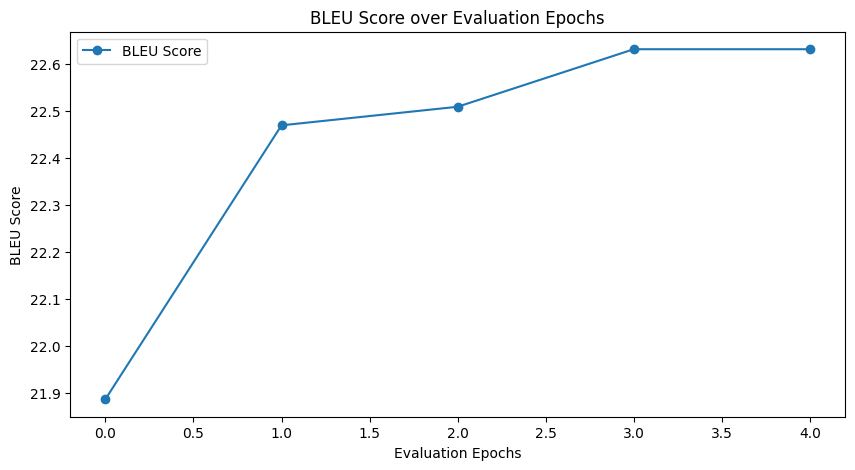

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, marker='o', label="BLEU Score")
plt.xlabel("Evaluation Epochs")
plt.ylabel("BLEU Score")
plt.title("BLEU Score over Evaluation Epochs")
plt.legend()
plt.show()

In [24]:
class TestDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = [json.loads(line) for line in f]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        source = item['source']
        inputs = self.tokenizer(
            source, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt'
        )
        return {
            'id': item['id'],
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze()
        }

In [25]:
# Load Test Data
test_dataset = TestDataset('/kaggle/input/semeval.test_hidden/test_without_targets/ar_AE.jsonl', tokenizer)

In [55]:
test_dataset[1]

{'id': 'Q1006293',
 'input_ids': tensor([256047,  82420,    373,   6606,  15520,    349,  91053,  40631,   3189,
            452, 183663, 113677,   6957,    983, 248130,      2,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,     

In [44]:
test_dataset[0]

{'id': 'Q1006293',
 'input_ids': tensor([256047,   7644,    248,    349,   8385,  92372,    452,    349,  91053,
          40631,   3189,    452, 183663, 113677, 248130,      2,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,     

In [26]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
# predictions.append({
#     "id": batch['id'][0].item(),  # Convert tensor to integer
#     "source_language": "English",
#     "target_language": "Arabic",
#     "text": source_text,
#     "prediction": prediction
# })

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): M2M100ForConditionalGeneration(
      (model): M2M100Model(
        (shared): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
        (encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_featu

In [47]:
device

device(type='cuda')

In [28]:
model.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): M2M100ForConditionalGeneration(
      (model): M2M100Model(
        (shared): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
        (encoder): M2M100Encoder(
          (embed_tokens): M2M100ScaledWordEmbedding(128112, 1024, padding_idx=1)
          (embed_positions): M2M100SinusoidalPositionalEmbedding()
          (layers): ModuleList(
            (0-11): 12 x M2M100EncoderLayer(
              (self_attn): M2M100SdpaAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_featu

In [29]:
test_jsonl_path = "/kaggle/input/semeval.test_hidden/test_without_targets/ar_AE.jsonl"
source_texts = {}

with open(test_jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        source_texts[data["id"]] = data["source"]

In [ ]:
source_texts

In [33]:
len(source_texts)

5108

In [30]:
predictions = []

for batch in tqdm(test_dataloader, desc="Generating Predictions", colour="blue"):
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=batch["input_ids"].to(model.device),
            attention_mask=batch["attention_mask"].to(model.device),
            max_length=128
        )
        prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        batch_id = batch["id"][0]  
        source_text = source_texts[batch_id]

        # print(f"The source text is: {source_text}")
        # print(f"The prediction text is: {prediction}")
        
        predictions.append({
            "id": batch_id,
            "source_language": "English",
            "target_language": "Arabic",
            "text": source_text,
            "prediction": prediction
        })
        # print(predictions)

Generating Predictions: 100%|██████████| 4547/4547 [42:33<00:00,  1.78it/s]  


In [31]:
predictions[:5]

[{'id': '5a6a722a7761adcb',
  'source_language': 'English',
  'target_language': 'Arabic',
  'text': 'Who is the main character in Ainbo: Spirit of the Amazon?',
  'prediction': 'من هو الشخصية الرئيسية في فيلم آينبو: روح الأمازون؟'},
 {'id': '39a50d7811b99483',
  'source_language': 'English',
  'target_language': 'Arabic',
  'text': 'When was Ainbo: Spirit of the Amazon released?',
  'prediction': 'متى تم إصدار آينبو: روح الأمازون؟'},
 {'id': 'cf86998bd11ee2c4',
  'source_language': 'English',
  'target_language': 'Arabic',
  'text': 'What is the genre of Ainbo: Spirit of the Amazon?',
  'prediction': 'ما هو نوع آينبو: روح الأمازون؟'},
 {'id': 'e7755ed89bd47020',
  'source_language': 'English',
  'target_language': 'Arabic',
  'text': 'How long has the Bornay Mosque been a place of worship in Qazan?',
  'prediction': 'كم من الوقت استمرت مساجد بورناي في مكان العبادة في قازان؟'},
 {'id': 'be9db1c788ad0fe5',
  'source_language': 'English',
  'target_language': 'Arabic',
  'text': 'What is

In [44]:
len(predictions)

5108

In [32]:
# Save Predictions
with open('ar_AE_m2m100_418M-v1.jsonl', 'w') as f:
    for pred in predictions:
        f.write(json.dumps(pred, ensure_ascii=False) + '\n')